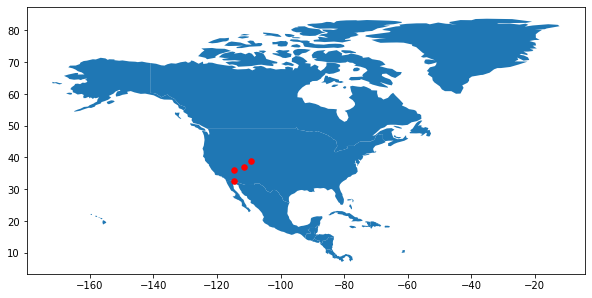

In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt


df = pd.read_csv("./lon_lat.txt", delimiter=',', skiprows=0, low_memory=False)

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.continent == 'North America']
gdf.plot(ax=usa.plot(figsize=(10, 6)), marker='o', color='red', markersize=30)

plt.show()

In [2]:
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20,5.5)

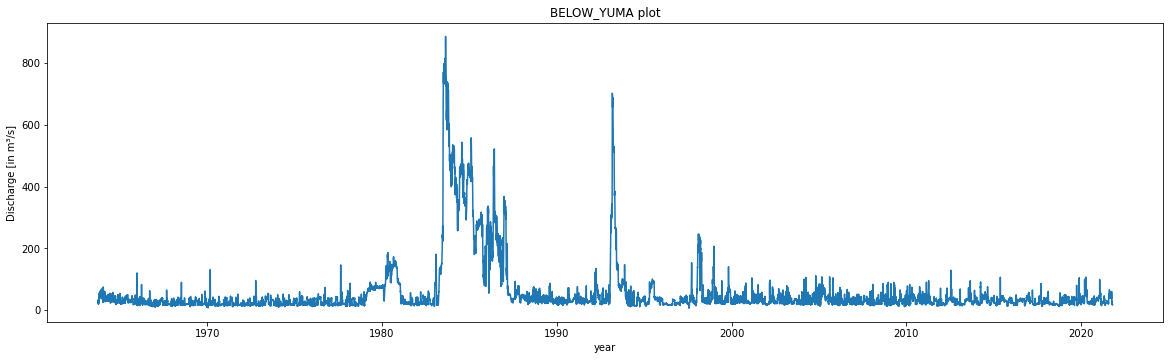

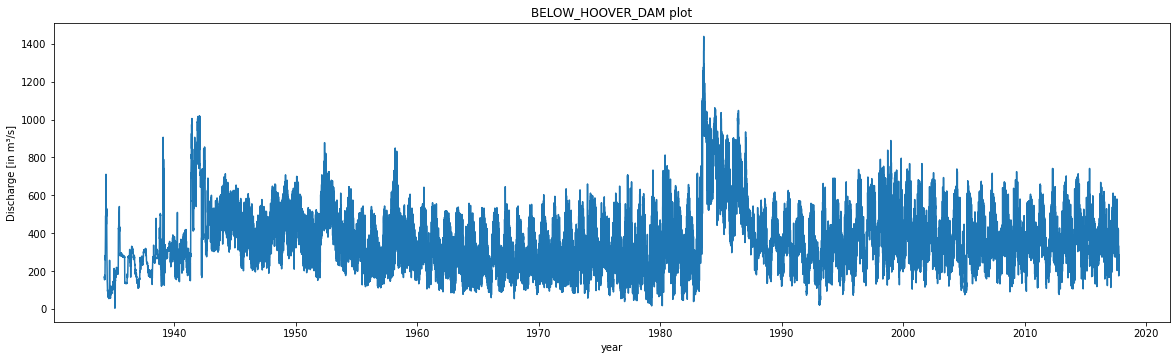

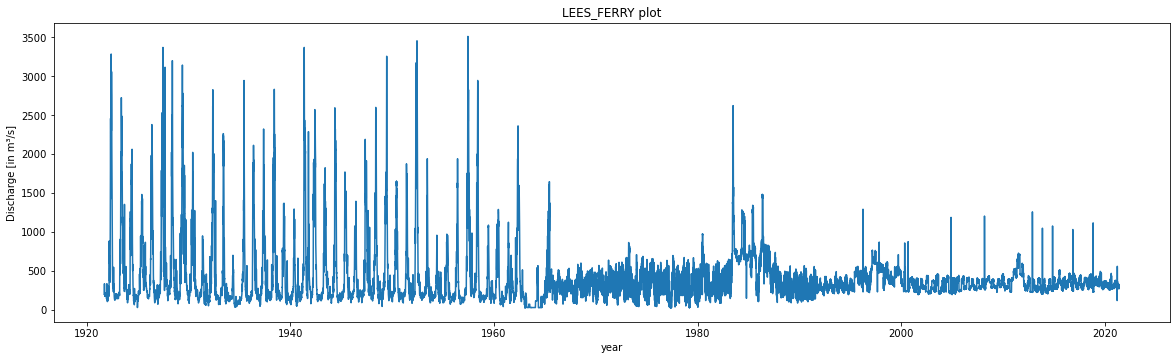

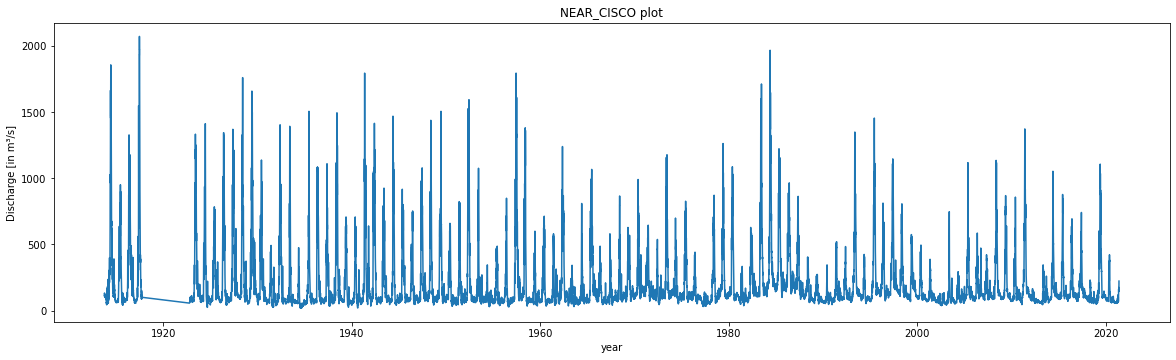

In [3]:
#Import txt files from internet and quick visualization.
format = '%Y-%m-%d'
def import_format(path):
    df = pd.read_csv(path, delimiter=';', skiprows=0, low_memory=False, index_col=0)                
    df.index = pd.to_datetime(df.index,format=format)
    df=df.drop("hh:mm",axis=1)
    df=df[df.iloc[:, 0]>0]
    return df
BELOW_YUMA=import_format("./data/4152050_Q_Day.Cmd.txt")
BELOW_HOOVER_DAM=import_format("./data/4152103_Q_Day.Cmd.txt")
LEES_FERRY=import_format("./data/4152450_Q_Day.Cmd.txt")
NEAR_CISCO=import_format("./data/4152460_Q_Day.Cmd.txt")

def plot_points(x,name,show=0):
    plt.plot(x)
    plt.title(f"{name} plot")
    plt.xlabel("year")
    plt.ylabel("Discharge [in m³/s]")
    if show == 0:
        plt.show()
    
plot_points(BELOW_YUMA,"BELOW_YUMA")
plot_points(BELOW_HOOVER_DAM,"BELOW_HOOVER_DAM")
plot_points(LEES_FERRY,"LEES_FERRY")
plot_points(NEAR_CISCO,"NEAR_CISCO")

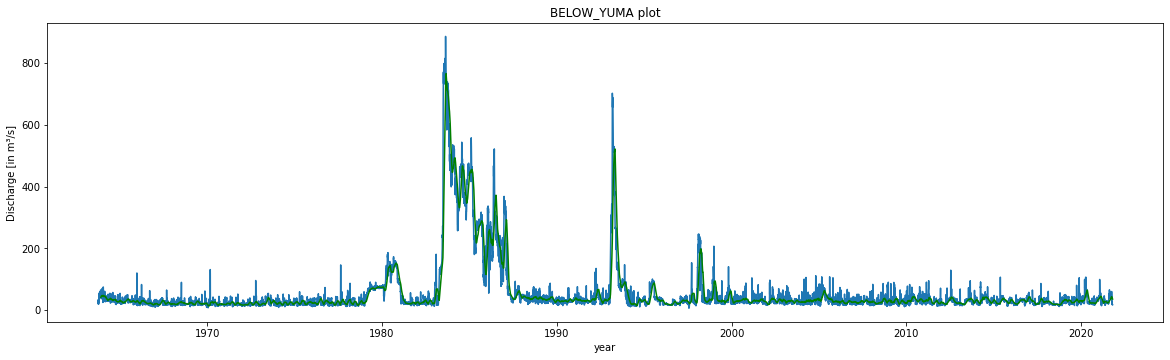

In [4]:
#aquire rolling mean:
rolmean=BELOW_YUMA.rolling(window=60).mean()

main_6=plot_points(BELOW_YUMA,"BELOW_YUMA",1)
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 


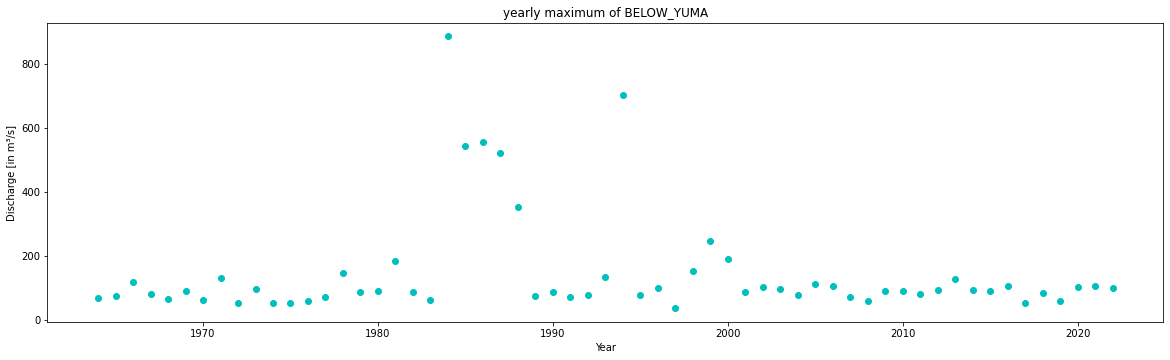

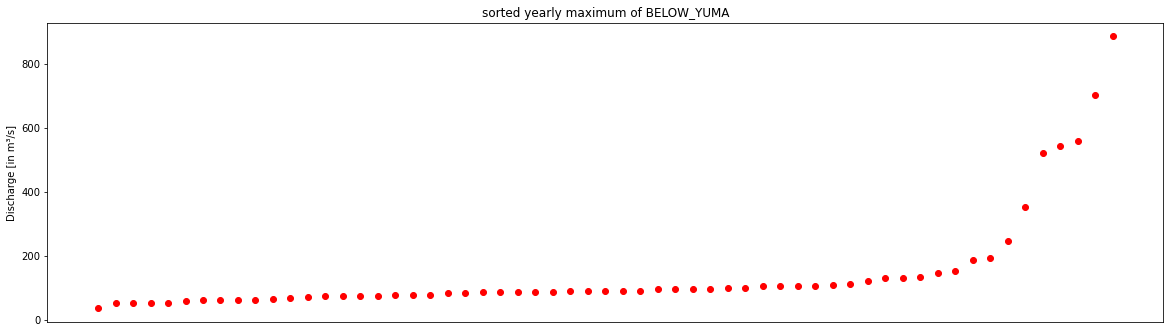

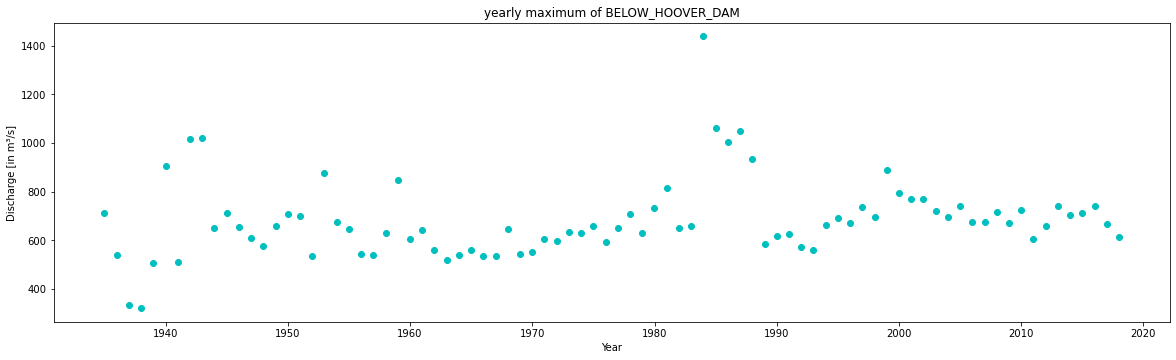

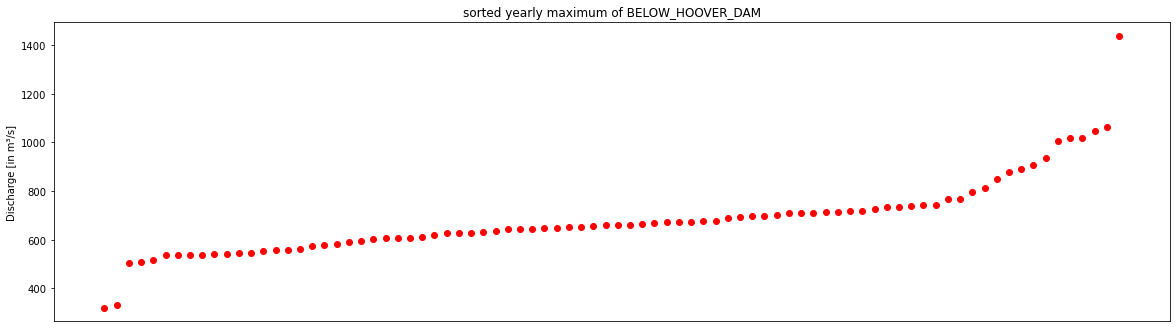

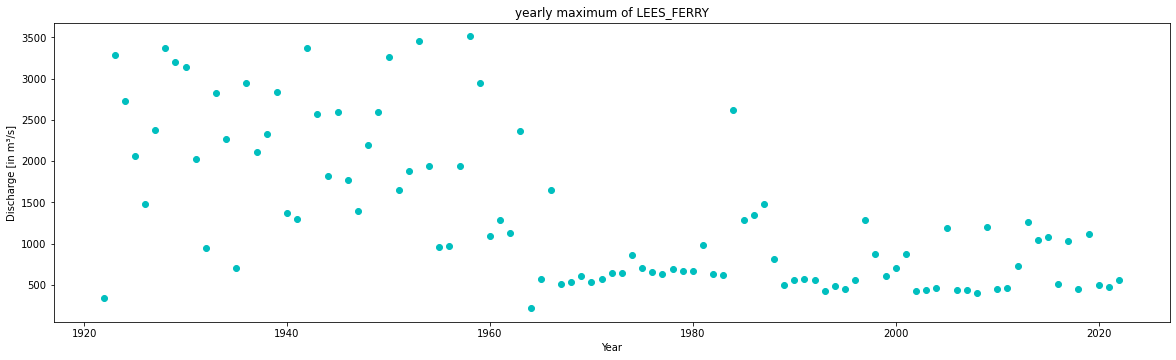

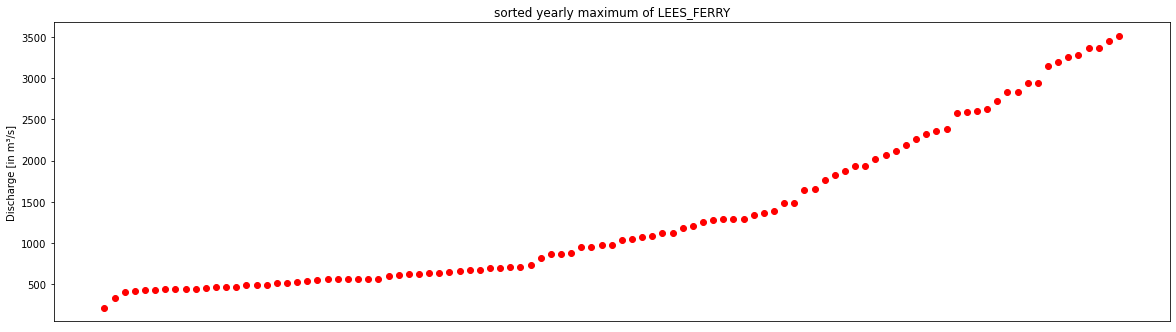

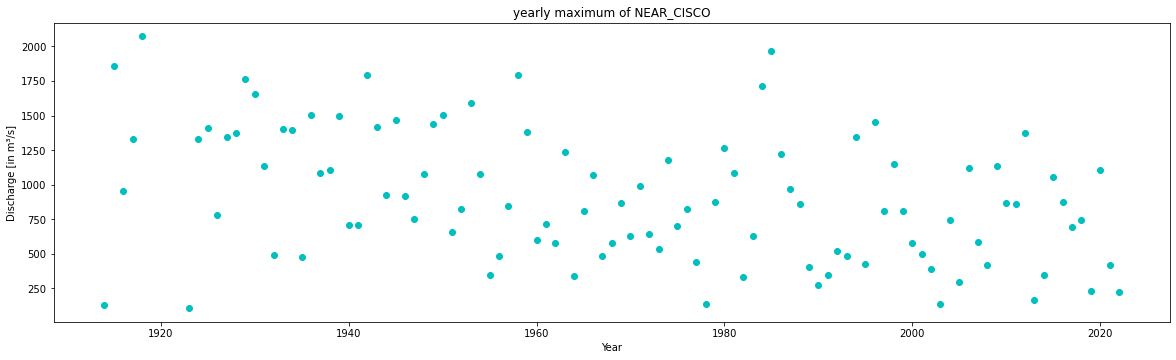

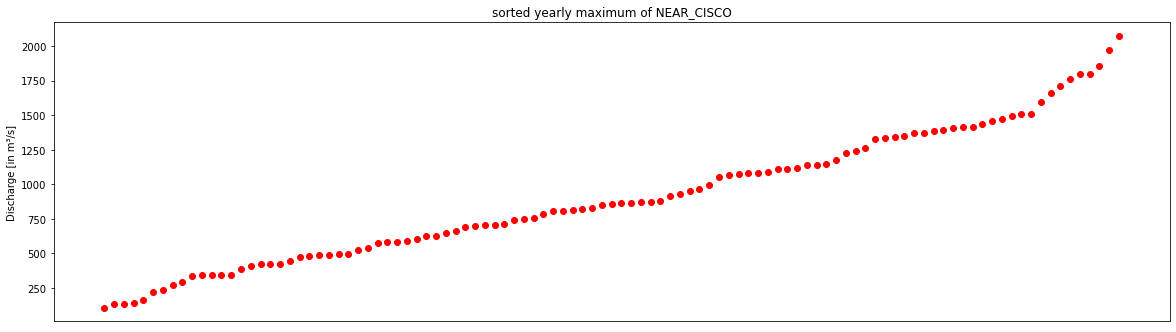

In [5]:
#finding yearly max

def plot_maximum_every_year(data, name):
    df=data
    df.rename(columns={" Value":"Value"},inplace=True)
    df.index = pd.to_datetime(df.index)
    test=df.resample('1y').Value.agg([min, max])
    #unsorted
    plt.scatter(test.index,test["max"],color="c")
    plt.title(f"yearly maximum of {name}")
    plt.xlabel("Year")
    plt.ylabel("Discharge [in m³/s]")
    plt.show()
    #sorted
    test=test.reset_index()
    test = test.sort_values(['max'], ascending=[True])
    test=test.reset_index()
    test=test[["max","min"]]
    
    plt.scatter(test.index,test["max"],color="red")
    plt.title(f"sorted yearly maximum of {name}")
    plt.ylabel("Discharge [in m³/s]")
    plt.xticks([])
    plt.show()

plot_maximum_every_year(BELOW_YUMA,"BELOW_YUMA")
plot_maximum_every_year(BELOW_HOOVER_DAM,"BELOW_HOOVER_DAM")
plot_maximum_every_year(LEES_FERRY,"LEES_FERRY")
plot_maximum_every_year(NEAR_CISCO,"NEAR_CISCO")


----------- BELOW_YUMA -----------
mean(logQ)= 6.554299433894801
max(logQ)= 6.554299433894801
min(logQ)= 4.635504390003744
std(logQ)= 0.6097168354559145
----------------------------------


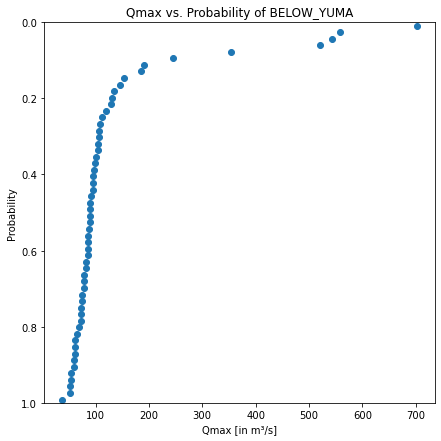

C:\Users\claud\AppData\Local\Temp\ipykernel_18264\512777821.py:61: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,5000)


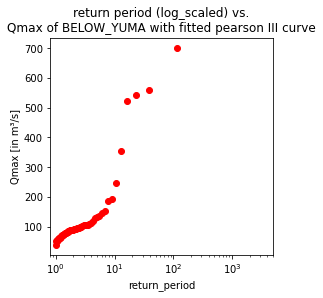


----------- BELOW_HOOVER_DAM -----------
mean(logQ)= 6.96779620106726
max(logQ)= 6.96779620106726
min(logQ)= 6.492972700243209
std(logQ)= 0.20575711607636973
----------------------------------


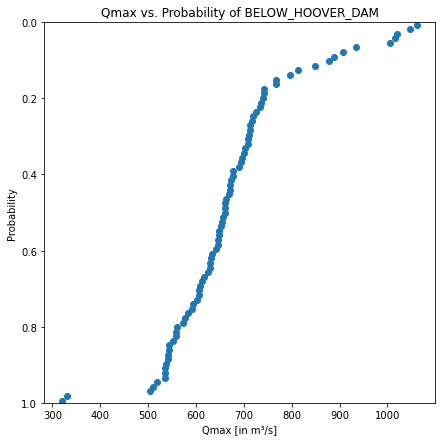

C:\Users\claud\AppData\Local\Temp\ipykernel_18264\512777821.py:61: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,5000)


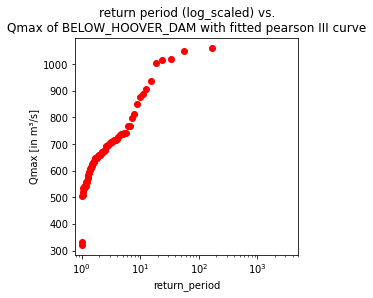


----------- LEES_FERRY -----------
mean(logQ)= 8.147476428610126
max(logQ)= 8.147476428610126
min(logQ)= 6.942677431248175
std(logQ)= 0.6914721347378612
----------------------------------


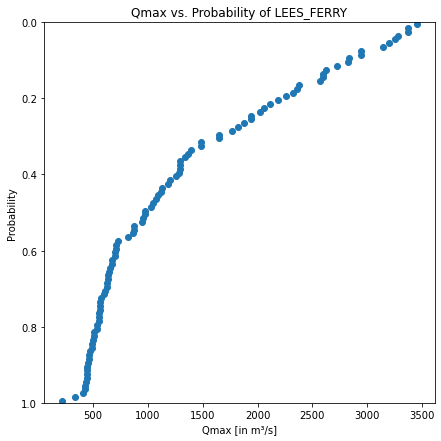

C:\Users\claud\AppData\Local\Temp\ipykernel_18264\512777821.py:61: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,5000)


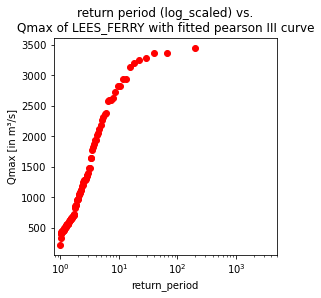


----------- NEAR_CISCO -----------
mean(logQ)= 7.5847822239118345
max(logQ)= 7.5847822239118345
min(logQ)= 6.6291777209323515
std(logQ)= 0.6412278487984857
----------------------------------


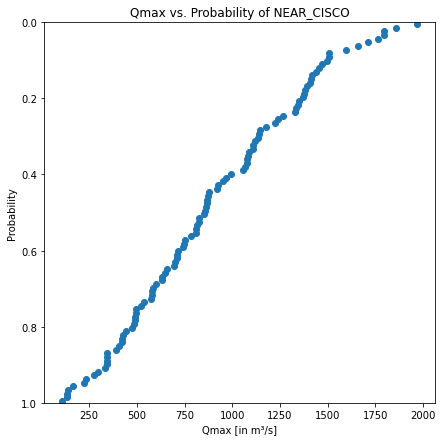

C:\Users\claud\AppData\Local\Temp\ipykernel_18264\512777821.py:61: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,5000)


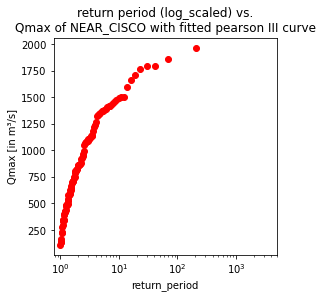

In [6]:
import numpy as np
from scipy.stats import pearson3
import scipy.optimize as opt
from scipy.stats import linregress

def abline(slope, intercept):
    """Plot a line from slope and intercept: source: """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
    
def calculate_probability(data,name):
    plt.rcParams["figure.figsize"] = (7,7)
    df=data
    df.rename(columns={" Value":"Value"},inplace=True)
    df.index = pd.to_datetime(df.index)
    test=df.resample('1y').Value.agg([min, max])
    
    test=test.reset_index()
    test = test.sort_values(['max'], ascending=[True])
    test=test.reset_index()
    test=test[["max","min"]]
    
    #calculate probability and return new DataFrame
    test=test.reset_index()
    test["rank"]=test["index"]+1
    test=test[["rank","max","min"]]
    test=test.dropna()
    n=len(test)-1
    test["p"]=1-((test["rank"]-0.5)/n)
    

    #calculate theoretical return period
    test["return_period"]=1/test["p"]
    test["Qmax_log"]=np.log(test["max"])
    test = test[test.return_period > 0]
    
    print(f"\n----------- {name} -----------")
    print(f"mean(logQ)= {max(test['Qmax_log'])}")
    print(f"max(logQ)= {max(test['Qmax_log'])}")
    print(f"min(logQ)= {test['Qmax_log'].mean()}")
    print(f"std(logQ)= {test['Qmax_log'].std()}")
    print("----------------------------------")
    
    #Estimating RIq
    plt.scatter(test["max"],test["p"])
    plt.title("")
    plt.autoscale()
    plt.ylim(1,0)
    plt.title(f"Qmax vs. Probability of {name}")
    plt.xlabel("Qmax [in m³/s]")
    plt.xscale("linear")
    plt.ylabel("Probability")
    plt.show()
    
    plt.rcParams["figure.figsize"] = (4,4)
    plt.scatter(test["return_period"],test["max"],color="red")
    plt.xscale("log")
    plt.xlim(0,5000)
    plt.title(f"return period (log_scaled) vs.\nQmax of {name} with fitted pearson III curve")
    plt.ylabel("Qmax [in m³/s]")

    plt.xlabel("return_period")
    plt.show()
#    ##fitting a linear regression (does not work?!):
#
#
#    mymodel = np.poly1d(np.polyfit(test["return_period"], test["max"], 3))
#    myline = np.linspace(1, 75, 4500)
#    plt.plot(myline, mymodel(myline))
#    plt.show() 



calculate_probability(BELOW_YUMA,"BELOW_YUMA")
calculate_probability(BELOW_HOOVER_DAM,"BELOW_HOOVER_DAM")
calculate_probability(LEES_FERRY,"LEES_FERRY")
calculate_probability(NEAR_CISCO,"NEAR_CISCO")